In [1]:
# Data Preparation

In [11]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [73]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [18]:
# Load the Valero daily data
df = pd.read_csv('../data/cleandata/Data.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
#df = df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
df.head()

,Crude1,WTI_Midland,Brent,RBOB,Ethanol,Corn,CAD_Heavy,VIX,ULSD,OPEC_Basket,RBOB_Crack,GC_ULSD_Crack,NY_ULSD_Crack,NG_HB,S_P,VLO
Date,,,,,,,,,,,,,,,,
2017-01-05,53.76,-0.06,56.89,1.6377,1.507,361.25,-15.044,13.025,1.6942,53.02,21.45,14.58,17.13,3.273,2264.3,60.913052
2017-01-06,53.99,-0.11,57.10,1.6340,1.551,358.00,-14.459,12.875,1.7032,53.50,21.45,14.69,17.27,3.285,2271.5,59.995037
2017-01-09,51.96,-0.22,54.94,1.5707,1.524,360.00,-14.296,12.925,1.6376,52.85,20.94,14.27,16.68,3.103,2265.0,59.734032
2017-01-10,50.82,-0.17,53.64,1.5467,1.503,358.25,-14.193,12.875,1.6114,51.46,21.15,14.44,16.72,3.278,2263.7,59.878029
2017-01-11,52.25,-0.17,55.10,1.5929,1.492,357.25,-14.232,12.525,1.6524,50.98,21.64,14.67,16.96,3.224,2270.6,60.373043


In [56]:
number_units = 10
dropout_fraction = 0.2

In [75]:
def LSTM_F(df):


    def window_data(df, window, feature_col_number, target_col_number):
        X = []
        y = []
        for i in range(len(df) - window - 1):
            features = df.iloc[i:(i + window), feature_col_number]
            target = df.iloc[(i + window), target_col_number]
            X.append(features)
            y.append(target)
        return np.array(X), np.array(y).reshape(-1, 1)

    window_size =3

    # Column index 1 is the `Close` column
    feature_column = 15
    target_column = 15
    X, y = window_data(df, window_size, feature_column, target_column)
    
    # Use 70% of the data for training and the remainder for testing
    split = int(0.7 * len(X))
    X_train = X[: split - 1]
    X_test = X[split:]
    y_train = y[: split - 1]
    y_test = y[split:]
    
    # Use MinMaxScaler to scale the data between 0 and 1. 
    

    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()

    number_units = 10
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #train the model
    
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)    
   
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))    
    
    model_eval = model.evaluate(X_test, y_test)
        
   
        
    
    stocks = pd.DataFrame({"Real": real_prices.ravel(),"Predicted": predicted_prices.ravel()})   
    stocks_ =stocks.tail()
    stocks_plot = stocks.plot()    
    
    return  model_eval, stocks, stocks_plot  


Train on 419 samples
Epoch 1/10
419/419 [==============================] - 23s 54ms/sample - loss: 0.0074
Epoch 2/10
419/419 [==============================] - 5s 13ms/sample - loss: 0.0265
Epoch 3/10
419/419 [==============================] - 5s 11ms/sample - loss: 0.0243
Epoch 4/10
419/419 [==============================] - 4s 10ms/sample - loss: 0.0164
Epoch 5/10
419/419 [==============================] - 3s 8ms/sample - loss: 0.0107
Epoch 6/10
419/419 [==============================] - 3s 8ms/sample - loss: 0.0082
Epoch 7/10
419/419 [==============================] - 3s 7ms/sample - loss: 0.0072
Epoch 8/10
419/419 [==============================] - 3s 7ms/sample - loss: 0.0066
Epoch 9/10
419/419 [==============================] - 3s 7ms/sample - loss: 0.0066
Epoch 10/10
419/419 [==============================] - 3s 7ms/sample - loss: 0.0064
181/1 [========================================================================================================================================

(0.017978827111443597,            Real   Predicted
 0    109.008568  110.114494
 1    109.133141  110.024635
 2    110.704781  109.788788
 3    114.988464  109.583809
 4    112.333931  109.715141
 ..          ...         ...
 176   81.011757   83.941536
 177   79.874367   85.152054
 178   80.734825   87.155907
 179   83.998634   88.561699
 180   83.009605   88.405296
 
 [181 rows x 2 columns], <matplotlib.axes._subplots.AxesSubplot at 0x21d08c096c8>)

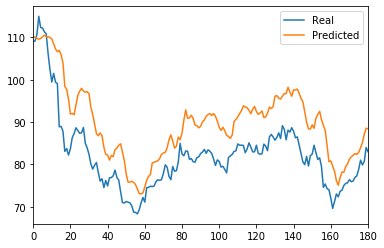

In [76]:
LSTM_F(df)

In [ ]:
# Compile the model
